# Import Libaries

In [12]:
import argparse
import warnings
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import time
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import optuna
import copy

from torch.optim.lr_scheduler import ReduceLROnPlateau
# import mse 
from sklearn.metrics import mean_squared_error
import pandas as pd
from utils.ml_helper_functions import load_data, load_data_v2

import torch.nn as nn

torch.manual_seed(42)

np.random.seed(42)

## Load Data

In [13]:
df_loaded = load_data()


Loading data from:
../data/numerical_data/points30
../data/numerical_data/points10

Loading ocean, weather and insitu data...

Shapes of loaded DataFrames before feature engineering:
Ocean DataFrame: (9415187, 14)
Weather DataFrame: (2018400, 22)
Insitu DataFrame: (20161, 2)

Feature engineering...

Shapes of loaded DataFrames after feature engineering:
Ocean DataFrame: (9415187, 11)
Weather DataFrame: (2018400, 8)
Insitu DataFrame: (20161, 2)

Converting DataFrames to xarray DataArrays...

Running EOF analysis on ocean and weather data...

Converting DataArrays with PCs back to DataFrames...

Merging PCs with insitu data...

Shape of merged DataFrame with PCs: (20161, 98)

Preparing ML data...

Sum of NaN values in each column:
ds              0
bottomT_PC_1    0
bottomT_PC_2    0
bottomT_PC_3    0
bottomT_PC_4    0
               ..
wind_v_PC_6     0
wind_v_PC_7     0
wind_v_PC_8     0
y               0
unique_id       0
Length: 99, dtype: int64
Shape of prepared ML DataFrame: (2016

In [14]:
df = df_loaded.copy()

In [15]:
df.shape

(20161, 99)

In [16]:
df.head()

,ds,bottomT_PC_1,bottomT_PC_2,bottomT_PC_3,bottomT_PC_4,sla_PC_1,sla_PC_2,sla_PC_3,so_PC_1,so_PC_2,...,wind_v_PC_1,wind_v_PC_2,wind_v_PC_3,wind_v_PC_4,wind_v_PC_5,wind_v_PC_6,wind_v_PC_7,wind_v_PC_8,y,unique_id
0,2022-12-03 00:00:00,-0.303945,-1.571631,-0.796631,0.568800,-1.005268,-0.822924,0.530070,-0.218220,-0.897083,...,-0.910458,-1.380508,-0.336356,-0.663772,-0.176910,1.683785,0.216442,-1.537871,0.487133,Flensburg
1,2022-12-03 01:00:00,-0.305888,-1.570625,-0.795225,0.571684,-1.002811,-0.833910,0.528256,-0.210618,-0.893305,...,-0.891139,-1.419401,-0.342445,-0.626422,-0.157994,1.578949,-0.004670,-1.594176,0.463563,Flensburg
2,2022-12-03 02:00:00,-0.306904,-1.571336,-0.795739,0.570574,-1.006549,-0.904703,0.446098,-0.205510,-0.893562,...,-0.854349,-1.451191,-0.345683,-0.446534,-0.018121,1.552726,-0.105363,-1.581817,0.373853,Flensburg
3,2022-12-03 03:00:00,-0.308250,-1.573073,-0.795607,0.568620,-1.015887,-1.027999,0.293744,-0.205313,-0.898010,...,-0.807180,-1.425731,-0.376710,-0.361506,0.143657,1.486232,-0.122655,-1.909946,0.285051,Flensburg
4,2022-12-03 04:00:00,-0.309479,-1.574358,-0.794477,0.567034,-1.026219,-1.160469,0.123971,-0.204544,-0.909398,...,-0.740946,-1.414792,-0.440172,-0.340720,0.269567,1.562165,-0.147440,-2.029732,0.238839,Flensburg


In [17]:
df.drop(columns=["unique_id"], inplace=True)

In [18]:
# Calculating lagged features for all the columns which are numerical
for col in df.select_dtypes(include=[np.number]).columns:
    for lag in range(1, 7):
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)

        #df[f'{col}_future_{lag}'] = df[col].shift(-lag)

df.dropna(inplace=True)

In [19]:
df.head()

,ds,bottomT_PC_1,bottomT_PC_2,bottomT_PC_3,bottomT_PC_4,sla_PC_1,sla_PC_2,sla_PC_3,so_PC_1,so_PC_2,...,wind_v_PC_8_lag_3,wind_v_PC_8_lag_4,wind_v_PC_8_lag_5,wind_v_PC_8_lag_6,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6
6,2022-12-03 06:00:00,-0.312929,-1.577621,-0.789427,0.565287,-1.046446,-1.316206,-0.095753,-0.192486,-0.961201,...,-1.909946,-1.581817,-1.594176,-1.537871,0.190879,0.238839,0.285051,0.373853,0.463563,0.487133
7,2022-12-03 07:00:00,-0.315194,-1.578574,-0.785857,0.566916,-1.046160,-1.291914,-0.069276,-0.184501,-0.989670,...,-2.029732,-1.909946,-1.581817,-1.594176,0.123832,0.190879,0.238839,0.285051,0.373853,0.463563
8,2022-12-03 08:00:00,-0.317464,-1.579160,-0.783296,0.569445,-1.041916,-1.206734,0.043078,-0.177240,-1.006346,...,-1.917860,-2.029732,-1.909946,-1.581817,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853
9,2022-12-03 09:00:00,-0.319518,-1.579340,-0.781233,0.572660,-1.033751,-1.081472,0.210686,-0.170365,-1.011441,...,-1.804758,-1.917860,-2.029732,-1.909946,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051
10,2022-12-03 10:00:00,-0.320767,-1.578249,-0.779827,0.576759,-1.028013,-0.951460,0.384692,-0.164178,-1.005075,...,-1.722601,-1.804758,-1.917860,-2.029732,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839


In [20]:
# get the data from 21.10.2023 und zwei wochen vorher und danach
time_delta = pd.Timedelta(days=48) # 2 weeks
surge_date = pd.Timestamp("2023-10-21")
start_date = surge_date - time_delta
end_date = surge_date + time_delta

<Axes: title={'center': 'Surge Data'}, xlabel='ds'>

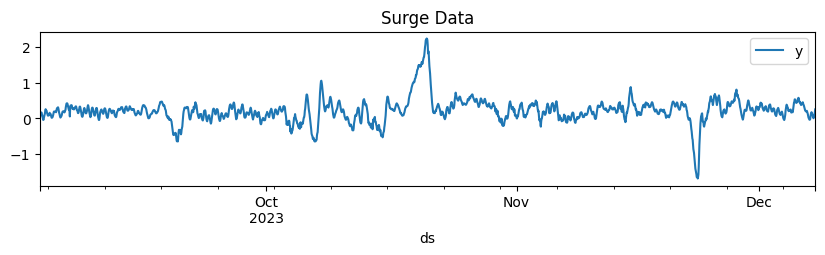

In [21]:
df_surge = df.loc[df.ds > start_date][df.ds < end_date].copy()
df_surge.plot(x="ds", y="y", kind="line", figsize=(10, 2), title="Surge Data")

<Axes: title={'center': 'Surge Data with NaN'}, xlabel='ds'>

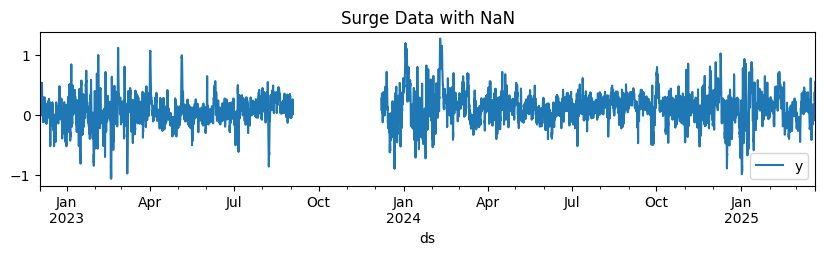

In [22]:
# make NaN values in range of start_date and end_date for all columns except 'ds'
df.loc[(df.ds > start_date) & (df.ds < end_date), df.columns != 'ds'] = np.nan

df.plot(x='ds', y="y", kind="line", figsize=(10, 2), title="Surge Data with NaN")



In [23]:
df_train = df.loc[df.ds < '2025-01-01'].copy()
df_val = df.loc[df.ds >= '2025-01-01'].copy()

In [24]:
display(df_train)
display(df_val)

,ds,bottomT_PC_1,bottomT_PC_2,bottomT_PC_3,bottomT_PC_4,sla_PC_1,sla_PC_2,sla_PC_3,so_PC_1,so_PC_2,...,wind_v_PC_8_lag_3,wind_v_PC_8_lag_4,wind_v_PC_8_lag_5,wind_v_PC_8_lag_6,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6
6,2022-12-03 06:00:00,-0.312929,-1.577621,-0.789427,0.565287,-1.046446,-1.316206,-0.095753,-0.192486,-0.961201,...,-1.909946,-1.581817,-1.594176,-1.537871,0.190879,0.238839,0.285051,0.373853,0.463563,0.487133
7,2022-12-03 07:00:00,-0.315194,-1.578574,-0.785857,0.566916,-1.046160,-1.291914,-0.069276,-0.184501,-0.989670,...,-2.029732,-1.909946,-1.581817,-1.594176,0.123832,0.190879,0.238839,0.285051,0.373853,0.463563
8,2022-12-03 08:00:00,-0.317464,-1.579160,-0.783296,0.569445,-1.041916,-1.206734,0.043078,-0.177240,-1.006346,...,-1.917860,-2.029732,-1.909946,-1.581817,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853
9,2022-12-03 09:00:00,-0.319518,-1.579340,-0.781233,0.572660,-1.033751,-1.081472,0.210686,-0.170365,-1.011441,...,-1.804758,-1.917860,-2.029732,-1.909946,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051
10,2022-12-03 10:00:00,-0.320767,-1.578249,-0.779827,0.576759,-1.028013,-0.951460,0.384692,-0.164178,-1.005075,...,-1.722601,-1.804758,-1.917860,-2.029732,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18235,2024-12-31 19:00:00,-0.584131,-0.614013,-0.269621,0.283882,1.457615,1.305080,-0.568677,1.257056,0.600762,...,0.818313,0.727700,0.394720,-0.107754,0.065000,0.168333,0.205000,0.241667,0.206667,0.103333
18236,2024-12-31 20:00:00,-0.587652,-0.613196,-0.263441,0.285923,1.479896,1.303972,-1.022421,1.293841,0.604203,...,1.022324,0.818313,0.727700,0.394720,-0.110000,0.065000,0.168333,0.205000,0.241667,0.206667
18237,2024-12-31 21:00:00,-0.589287,-0.612524,-0.259115,0.286310,1.492575,1.319430,-1.482426,1.324701,0.598391,...,1.635409,1.022324,0.818313,0.727700,-0.265000,-0.110000,0.065000,0.168333,0.205000,0.241667
18238,2024-12-31 22:00:00,-0.590708,-0.611164,-0.255194,0.285727,1.496793,1.409592,-1.872253,1.346701,0.590851,...,1.434405,1.635409,1.022324,0.818313,-0.316667,-0.265000,-0.110000,0.065000,0.168333,0.205000


,ds,bottomT_PC_1,bottomT_PC_2,bottomT_PC_3,bottomT_PC_4,sla_PC_1,sla_PC_2,sla_PC_3,so_PC_1,so_PC_2,...,wind_v_PC_8_lag_3,wind_v_PC_8_lag_4,wind_v_PC_8_lag_5,wind_v_PC_8_lag_6,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6
18240,2025-01-01 00:00:00,-0.594749,-0.606518,-0.246635,0.290304,1.511220,1.961435,-2.320812,1.362626,0.582624,...,1.796824,1.608027,1.434405,1.635409,-0.516667,-0.393333,-0.316667,-0.265000,-0.110000,0.065000
18241,2025-01-01 01:00:00,-0.596070,-0.601875,-0.232467,0.269744,1.500847,2.286545,-2.458659,1.368198,0.591566,...,2.533280,1.796824,1.608027,1.434405,-0.536667,-0.516667,-0.393333,-0.316667,-0.265000,-0.110000
18242,2025-01-01 02:00:00,-0.597046,-0.598618,-0.229393,0.266700,1.470679,2.576662,-2.557171,1.370120,0.598481,...,2.682510,2.533280,1.796824,1.608027,-0.566667,-0.536667,-0.516667,-0.393333,-0.316667,-0.265000
18243,2025-01-01 03:00:00,-0.598216,-0.595379,-0.227157,0.267686,1.428973,2.839926,-2.605468,1.371592,0.607398,...,2.555156,2.682510,2.533280,1.796824,-0.638333,-0.566667,-0.536667,-0.516667,-0.393333,-0.316667
18244,2025-01-01 04:00:00,-0.598849,-0.591694,-0.224628,0.263314,1.385750,3.037917,-2.669885,1.371422,0.617123,...,1.738916,2.555156,2.682510,2.533280,-0.676667,-0.638333,-0.566667,-0.536667,-0.516667,-0.393333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20156,2025-03-21 20:00:00,-0.852832,0.304002,0.242566,-0.543267,-0.450593,-1.642004,0.088681,-0.618588,-0.563127,...,-0.175218,-0.095271,-0.441699,-0.723018,0.420000,0.336667,0.275000,0.231667,0.245000,0.278333
20157,2025-03-21 21:00:00,-0.854031,0.301599,0.241763,-0.543499,-0.465324,-1.552174,0.280006,-0.615991,-0.559928,...,-0.506669,-0.175218,-0.095271,-0.441699,0.483333,0.420000,0.336667,0.275000,0.231667,0.245000
20158,2025-03-21 22:00:00,-0.855638,0.299369,0.241838,-0.543754,-0.475831,-1.457704,0.445328,-0.610756,-0.563381,...,-0.701652,-0.506669,-0.175218,-0.095271,0.496667,0.483333,0.420000,0.336667,0.275000,0.231667
20159,2025-03-21 23:00:00,-0.857216,0.297495,0.242355,-0.543240,-0.483009,-1.387714,0.528586,-0.603634,-0.579456,...,-1.052708,-0.701652,-0.506669,-0.175218,0.538333,0.496667,0.483333,0.420000,0.336667,0.275000


In [25]:
def create_sequences(df, seq_len=168, horizon=1):
    """
    Erzeugt nur Sequenzen, die innerhalb eines zusammenhängenden Bereichs liegen.
    """

    X_data = df.drop(columns=["y"]).set_index("ds").to_numpy()
    y_data = df[["ds", "y"]].set_index("ds").to_numpy()



    X, y = [], []
    for i in range(len(X_data) - seq_len - horizon + 1):
        window_x = X_data[i:i+seq_len+horizon] 
        window_y = y_data[i:i+seq_len+horizon]

        # Sicherheitscheck: Kein NaN und Index ist lückenlos
        if np.any(np.isnan(window_x)) or np.any(np.isnan(window_y)):
            continue  # überspringen
        X.append(window_x[:seq_len])
        y.append(window_y[seq_len:seq_len+horizon, 0])  
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(df_train, seq_len=168, horizon=168)
X_val, y_val = create_sequences(df_val, seq_len=168, horizon=168)
X_test, y_test = create_sequences(df_surge, seq_len=168, horizon=168)

print("\nTrain shapes:")
print(X_train.shape, y_train.shape, type(X_train), type(y_train))

print("\nValidation shapes:")
print(X_val.shape, y_val.shape, type(X_val), type(y_val))

print("\nTest shapes:")
print(X_test.shape, y_test.shape, type(X_test), type(y_test))


Train shapes:
(15261, 168, 678) (15261, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>

Validation shapes:
(1586, 168, 678) (1586, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>

Test shapes:
(1968, 168, 678) (1968, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


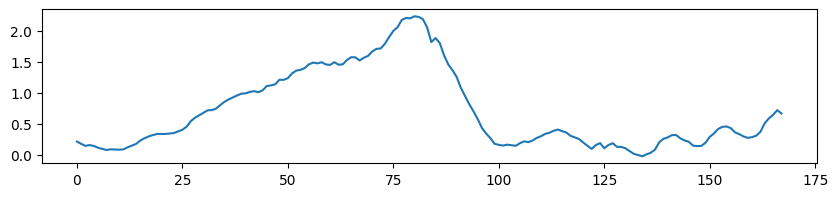

In [26]:
plt.figure(figsize=(10, 2))
plt.plot(y_test[900], label='Surge Data')
plt.show()

In [27]:
# Scaling x data


x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = x_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = x_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)



print("Scaled shapes:")
print(X_train_scaled.shape, y_train.shape, type(X_train_scaled), type(y_train))
print(X_val_scaled.shape, y_val.shape, type(X_val_scaled), type(y_val))
print(X_test_scaled.shape, y_test.shape, type(X_test_scaled), type(y_test))

Scaled shapes:
(15261, 168, 678) (15261, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1586, 168, 678) (1586, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1968, 168, 678) (1968, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [28]:
# # Scaling y_train and y_test
# y_scaler = StandardScaler()
# y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
# y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
# y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# print("Scaled y shapes:")
# print(y_train_scaled.shape, type(y_train_scaled))
# print(y_val_scaled.shape, type(y_val_scaled))
# print(y_test_scaled.shape, type(y_test_scaled))

In [29]:
import torch

# Numpy → Tensor
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print("\nTensor shapes:")
print(X_train_tensor.shape, y_train_tensor.shape, type(X_train_tensor), type(y_train_tensor))
print(X_val_tensor.shape, y_val_tensor.shape, type(X_val_tensor), type(y_val_tensor))
print(X_test_tensor.shape, y_test_tensor.shape, type(X_test_tensor), type(y_test_tensor))


Tensor shapes:
torch.Size([15261, 168, 678]) torch.Size([15261, 168]) <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1586, 168, 678]) torch.Size([1586, 168]) <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1968, 168, 678]) torch.Size([1968, 168]) <class 'torch.Tensor'> <class 'torch.Tensor'>


In [38]:
import optuna # Load optuna study
def open_study_db(db_name):
    storage = f'sqlite:///{db_name}'
    study_name_list = optuna.study.get_all_study_names(storage=storage)
    print(study_name_list)

    study_name = next((name for name in study_name_list))

    if study_name is None:
        raise ValueError(

            f"Verfügbare Studien: {study_name_list}"
        )
    return optuna.load_study(study_name=study_name, storage=storage)

study = open_study_db("optuna_study_FFNN.db")

print(study.best_params)

linear1_output = study.best_params["linear1_output"]
linear2_output = study.best_params["linear2_output"]
linear3_output = study.best_params["linear3_output"]
dropout = study.best_params["dropout"]
lr = study.best_params["lr"]



['fc_sequence_optimization']
{'linear1_output': 497, 'linear2_output': 321, 'linear3_output': 195, 'dropout': 0.37609066861548396, 'lr': 0.00310789588793112}


In [39]:
# visualize the study
optuna.visualization.plot_optimization_history(study).show()

optuna.visualization.plot_param_importances(study).show()

optuna.visualization.plot_parallel_coordinate(study).show()

In [40]:
import torch
import joblib
import numpy as np
from utils.Model_FFNN import FCSequencePredictor

# Hyperparameter erneut setzen
input_dim = 22  # Passe an deine Daten an
seq_len = 168
output_horizon = 168

# Modell initialisieren
model = FCSequencePredictor(
    input_dim=X_train_tensor.shape[2],
    seq_len=seq_len,
    linear1_output=linear1_output,
    linear2_output=linear2_output,
    linear3_output=linear3_output,
    output_horizon=output_horizon,
    n_classes=5,
    dropout=dropout,
)

# map 

# Modell-Gewichte laden
model.load_state_dict(torch.load("models/fcsequence_model.pth", map_location=torch.device('cpu')))
model.eval()

# Scaler laden
x_scaler = joblib.load("models/x_scaler.pkl")



In [43]:
X_test.shape

(1968, 168, 678)

In [44]:
# Neue Daten vorbereiten und skalieren
# X_new: shape (n_samples, seq_len, input_dim)
X_new_scaled = x_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32)

# Vorhersage
with torch.no_grad():
    y_pred, _ = model.predict(X_new_tensor.to(next(model.parameters()).device))


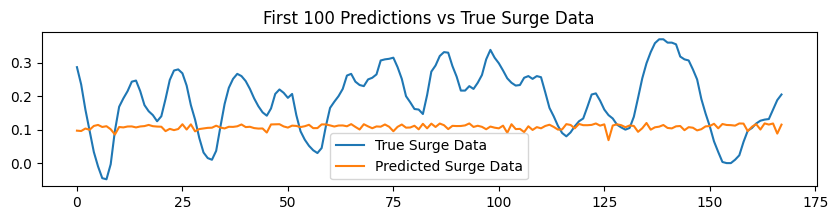

In [49]:
# plot the first 100 predictions
idx = 0
plt.figure(figsize=(10, 2))
plt.plot(y_test[idx], label='True Surge Data')
plt.plot(y_pred[idx], label='Predicted Surge Data')
plt.legend()
plt.title("First 100 Predictions vs True Surge Data")
plt.show()